In [1]:
import numpy as np
import skimage
import skimage.io
import skimage.transform
import skimage.morphology
import poie as ps

import matplotlib.pyplot as plt
from matplotlib.widgets import RectangleSelector
import matplotlib.animation as animation
import cv2

%matplotlib notebook

Загружаем фоновое изображение из набора.

In [2]:
back = skimage.io.imread('backgrounds/Starwars.jpg').astype(float)

Сделаем интерфейс для выбора области, куда будут вставляться изображения с вебкамеры.

<IPython.core.display.Javascript object>


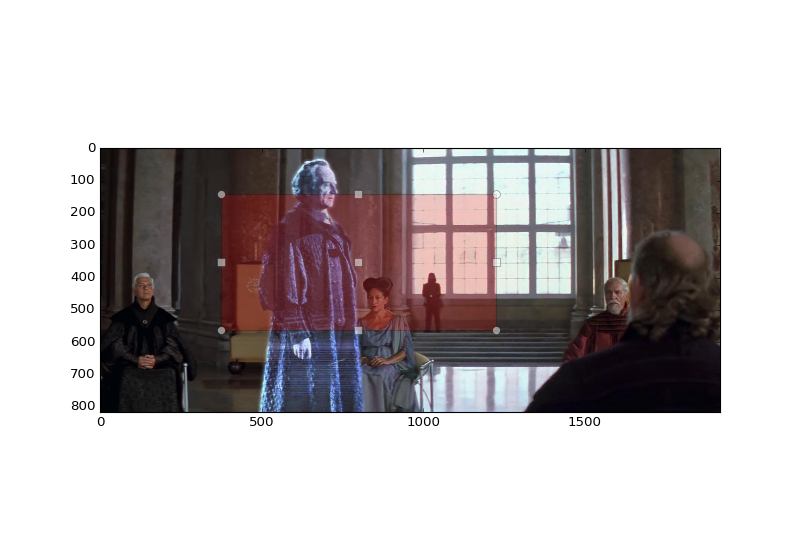

In [3]:
def onselect(click, release):
    pass
    
fig, ax = plt.subplots(figsize=(10, 7))
ax.imshow(ps.to_uint8(back))

toggle_selector = RectangleSelector(ax, onselect, interactive=True)
cid = fig.canvas.mpl_connect('key_press_event', toggle_selector)

plt.show()

Потребуется для захвата изображения с веб-камеры.

In [4]:
cam = cv2.VideoCapture(0)

Поместим в отмеченную область изображение с веб-камеры, обработанное с помощью метода максимума лапласиана.
К сожалению, отображение получается далеко не в реалтайм-режиме.
Можно сделать фотографию, остановив выполнение ячейки (нажать на кнопку выключения рядом с заголовком **Figure 2**) и затем просто сохранить изображение.

In [ ]:
fig, ax = plt.subplots(figsize=(10, 7))

#coordinates of top-left and down-right corners
xlim = np.array(toggle_selector.corners[0][:2]).astype(int)
ylim = np.array(toggle_selector.corners[1][1:3]).astype(int)
shape = (ylim[1] - ylim[0], xlim[1] - xlim[0])

def animate(i):
    _, image = cam.read()
    if image is not None:
        mask = np.zeros(back.shape[:2])
        mask[ylim[0]: ylim[1], xlim[0]: xlim[1]] = 1
        mask = skimage.morphology.binary_erosion(mask != 0)
        
        #resize image to background shape
        image = skimage.transform.resize(image, back.shape).astype(float) * 400
        
        #insert transformed image into background
        final = np.zeros_like(image)
        final[ylim[0]: ylim[1], xlim[0]: xlim[1]] = skimage.transform.resize(image, shape)
        res, _ = ps.poisson(1000, mask, back.copy(), ps.laplacian_absmax(final[..., ::-1], back))
        
        ax.imshow(ps.to_uint8(res))
    else:
        return

ani = animation.FuncAnimation(fig, animate, repeat=0, interval=25)

Может понадобиться остановка захвата видеопотока с камеры:

In [6]:
cam.release()

## Некоторые результаты

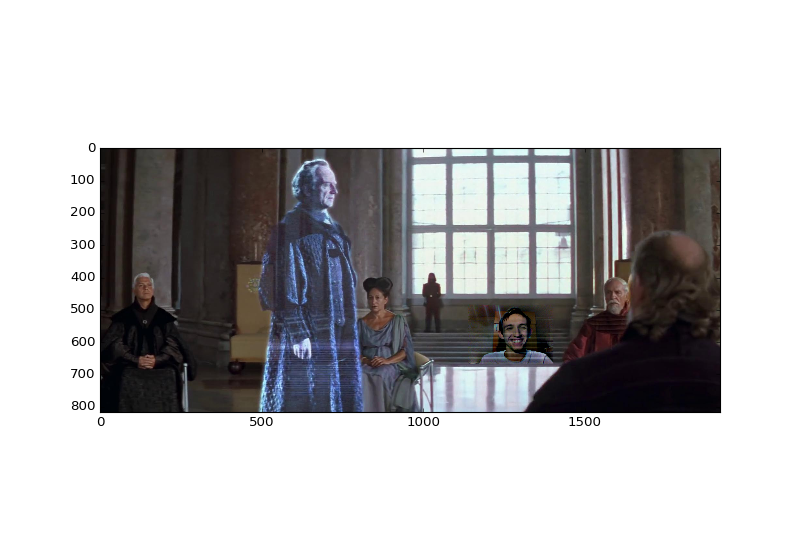

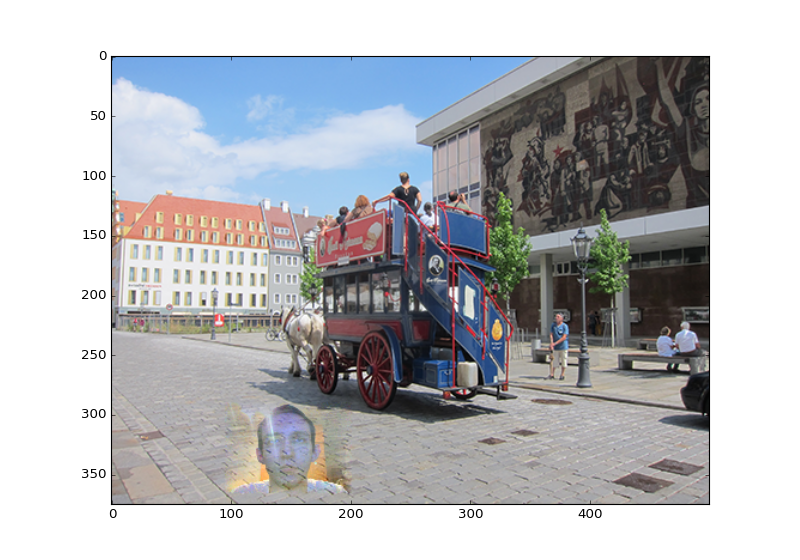

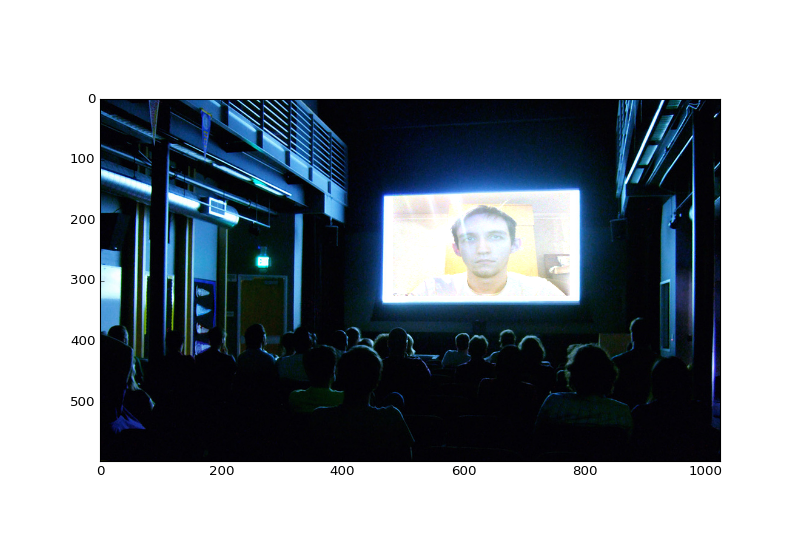

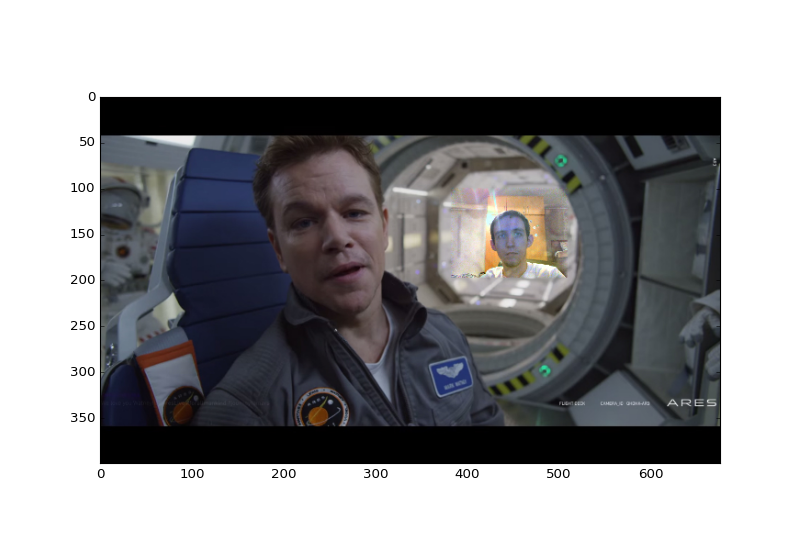

In [16]:
import os
from IPython.display import Image, display

for file  in os.scandir('results'):
    if not file.name.startswith('.'):
        display(Image(file.path))